In [2]:
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import fiona
import pyproj

import fiona
import geopandas as gpd
from shapely.geometry import mapping


import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 20)

In [11]:
urlpath_prev =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.{2021-1}.nc"
urlpath_current =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.{2021}.nc"
ds_previous = xr.open_dataset(urlpath_prev,decode_coords="all")
ds_current = xr.open_dataset(urlpath_current,decode_coords="all")

def trim_ds(ds, centroid):
    loc_lat = centroid[0]
    loc_lon = centroid[1]

    lat = ds.lat.values
    lon = ds.lon.values

    abs_lon = np.abs(lon - loc_lon)
    abs_lat = np.abs(lat - loc_lat)

    maxi = np.maximum(abs_lon,abs_lat)
    loc_index = np.argmin(maxi)


    ij = np.unravel_index(loc_index,(ds.dims['y'],ds.dims['x']))
    i_loc_index=ij[0]
    j_loc_index=ij[1]

    ds_local = ds.isel(y=slice(i_loc_index-1,i_loc_index+2),x=slice(j_loc_index-1,j_loc_index+1)).drop_dims('nbnds')
    return ds_local

ds = xr.concat([trim_ds(ds_previous,(38,-107)),trim_ds(ds_current,(38,-107))],dim='time')

ds.sel(time=slice('2020-10-1','2021-9-30'))

<xarray.Dataset>
Dimensions:            (time: 365, y: 3, x: 2)
Coordinates:
  * time               (time) datetime64[ns] 2020-10-01 ... 2021-09-30
  * y                  (y) float32 3.246e+06 3.279e+06 3.311e+06
  * x                  (x) float32 5.616e+06 5.649e+06
    Lambert_Conformal  int32 -2147483647
    lat                (y, x) float32 37.8 37.8 38.09 38.09 38.37 38.37
    lon                (y, x) float32 -107.2 -106.8 -107.2 -106.8 -107.2 -106.8
Data variables:
    apcp               (time, y, x) float32 0.0 0.0 0.0 ... 1.891 1.453 0.6953
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Sat Mar 26 04:56:06 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

In [12]:
def get_narr_precip(year, centroid):
    urlpath_prev =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.{year-1}.nc"
    urlpath_current =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.{year}.nc"
    ds_previous = xr.open_dataset(urlpath_prev,decode_coords="all")
    ds_current = xr.open_dataset(urlpath_current,decode_coords="all")

    ds = xr.concat([trim_ds(ds_previous,(38,-107)),trim_ds(ds_current,(38,-107))],dim='time')
    ds_wy = ds.sel(time=slice(f'{year-1}-10-1',f'{year}-9-30'))
    
    annual_precip = (ds_wy.apcp.sum()/(ds_wy.apcp.shape[1]*ds_wy.apcp.shape[2])) # kg/m2 * km2 / 1000**2 m2/km2 / 1 m3/1000 kg
    return ds_wy, annual_precip.values

def trim_ds(ds, centroid):
    loc_lat = centroid[0]
    loc_lon = centroid[1]

    lat = ds.lat.values
    lon = ds.lon.values

    abs_lon = np.abs(lon - loc_lon)
    abs_lat = np.abs(lat - loc_lat)

    maxi = np.maximum(abs_lon,abs_lat)
    loc_index = np.argmin(maxi)


    ij = np.unravel_index(loc_index,(ds.dims['y'],ds.dims['x']))
    i_loc_index=ij[0]
    j_loc_index=ij[1]

    ds_local = ds.isel(y=slice(i_loc_index-1,i_loc_index+2),x=slice(j_loc_index-1,j_loc_index+1)).drop_dims('nbnds')
    return ds_local

In [13]:
# get all NARR precip data
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
east_river_polygon = gpd.read_file("./East_River.kml", driver='KML')
centroid = east_river_polygon.centroid
years = np.arange(1980,2022,1)
narr_precip_totals = []
for year in years:
    if year % 10 == 0:
        print(f'Working in the {year}s')
    ds,annual_precip = get_narr_precip(year,(centroid.y.values, centroid.x.values))
    narr_precip_totals.append(annual_precip)


Working in the 1980s
Working in the 1981s
Working in the 1982s
Working in the 1983s
Working in the 1984s
Working in the 1985s
Working in the 1986s
Working in the 1987s
Working in the 1988s
Working in the 1989s
Working in the 1990s
Working in the 1991s
Working in the 1992s
Working in the 1993s
Working in the 1994s
Working in the 1995s
Working in the 1996s
Working in the 1997s
Working in the 1998s
Working in the 1999s
Working in the 2001s
Working in the 2002s
Working in the 2003s
Working in the 2004s
Working in the 2005s
Working in the 2006s
Working in the 2007s
Working in the 2008s
Working in the 2009s
Working in the 2010s
Working in the 2011s
Working in the 2012s
Working in the 2013s
Working in the 2014s
Working in the 2015s
Working in the 2016s
Working in the 2017s
Working in the 2018s
Working in the 2019s
Working in the 2020s
Working in the 2021s


In [18]:
import pandas as pd
precip_df=pd.Series(narr_precip_totals, index=years,name='narr_precip_totals_mm')
precip_df.to_csv('./data/narr_precip_1980_2022.csv')

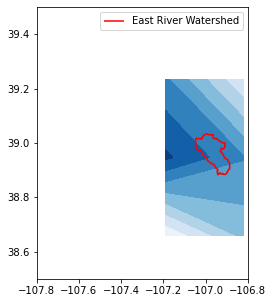

In [32]:
# Visualize one day of data
fig, ax=plt.subplots(figsize=(10,5))
ds_1day = ds.sel(time='2021-12-23')
ax.contourf(ds_1day.lon.values, ds_1day.lat.values, ds_1day.apcp.values, zorder=2, cmap='Blues')
east_river_polygon.boundary.plot(ax=ax, label='East River Watershed', color='red',zorder=10)

#Zoom in
extent=[-107.8,-106.8,38.5,39.5]

ax.set_xlim(*extent[0:2])
ax.set_ylim(*extent[2:])
ax.legend()

In [11]:
def plotMap():
    # adapted from https://www.guillaumedueymes.com/post/narr_synoptic/
    #Set the projection information
    proj = ccrs.LambertConformal(central_longitude=-107.0,central_latitude=50, standard_parallels=[50])
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([-130,-70,20,60]);
    
    #Add map features
    ax.add_feature(cartopy.feature.LAND, facecolor='0.9'); #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.9);  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cartopy.feature.BORDERS, zorder=10);
    ax.add_feature(cartopy.feature.COASTLINE, zorder=10);
    ax.add_feature(cartopy.feature.LAKES, zorder=10);


    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none');
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10);
    
    #Add lat/lon gridlines every 20° to the map
    ax.gridlines(xlocs=np.arange(0,361,20), ylocs=np.arange(-80,90,20));
    
    return fig, ax